<h2>Libraries and functions used throughout the notebook</h2>

In [14]:
import pandas as pd
from textblob import TextBlob
import matplotlib.pyplot as plt
import networkx as nx
import pycountry
import requests
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
import requests
from requests.exceptions import ConnectionError, Timeout, RequestException
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry

pd.set_option('display.max_rows', None) # Comment this out if needed

def get_sentiment(text):
    if text == 0:
        return 'NaN'
    return TextBlob(text).sentiment.polarity

def get_country_code(country_name):
    try:
        return pycountry.countries.lookup(country_name).alpha_3
    except LookupError:
        return None
    
def get_neighbors_from_api(country_code):
    print('testing')
    url = f"https://restcountries.com/v3.1/alpha/{country_code}"
    print('ok1')
    response = requests.get(url)
    print('ok2')
    if response.status_code == 200:
        country_data = response.json()
        return country_data[0].get('borders', [])
    return []

def get_neighbors(iso_code):
    if iso_code in G:
        return list(G.neighbors(iso_code))
    return []

def countries_in_conflict(year):
    return final_merged_dataframe[(final_merged_dataframe['year'] == year) & (final_merged_dataframe['intensity_level'] > 0)]['ISO-alpha3 Code'].dropna().values

def has_neighbor_in_conflict(row):
    if pd.isna(row['ISO-alpha3 Code']):
        return False
    neighbors = get_neighbors(row['ISO-alpha3 Code'])
    conflicting_countries = countries_in_conflict(row['year'])
    return any(neighbor in conflicting_countries for neighbor in neighbors)

def select_row(group):
    if (group['intensity_level'] == 2).any():
        return group[group['intensity_level'] == 2].iloc[0]
    elif (group['intensity_level'] == 1).any():
        return group[group['intensity_level'] == 1].iloc[0]
    else:
        return group.iloc[0]

<h2>Import the Datasets</h2>

A few country names in the datasets have been hardcoded to a more convenient name

In [15]:
# Happiness dataset

happinessdataframe = pd.read_csv('happiness_clean.csv')
happinessdataframe['Country Code'] = happinessdataframe['Country name'].apply(get_country_code)

happinessdataframe.loc[happinessdataframe['Country name'] == 'Congo (Brazzaville)', 'Country name'] = 'Congo'
happinessdataframe.loc[happinessdataframe['Country name'] == 'Congo (Kinshasa)', 'Country name'] = 'Congo'

In [16]:
# Conflict dataset

conflictdataframe = pd.read_csv('conflict_clean.csv')

conflict_post2004 = conflictdataframe[conflictdataframe['year'] > 2004]
conflict_post2004.loc[conflict_post2004['location'] == 'Russia (Soviet Union)', 'location'] = 'Russia'
conflict_post2004.loc[conflict_post2004['location'] == 'Russia (Soviet Union), Ukraine', 'location'] = 'Ukraine'
conflict_post2004.loc[conflict_post2004['location'] == 'DR Congo (Zaire)', 'location'] = 'Congo'

conflictdataframe = conflict_post2004

In [17]:
# UN Speeches

ungdc = pd.read_parquet('UNGDC_1946-2023_processed.parquet')

ungdc.head()

,Session,Year,ISO-alpha3 Code,Speech
0,01,1946,ARG,At the resumption of the first session of the ...
1,01,1946,AUS,The General Assembly of the United Nations is ...
2,01,1946,BEL,The\tprincipal organs of the United Nations ha...
3,01,1946,BLR,As more than a year has elapsed since the Unit...
4,01,1946,BOL,Coming to this platform where so many distingu...


<h2>Merging Datasets</h2>

In [18]:
# Merge happiness and conflict

merged_dataframe = pd.merge(
    happinessdataframe, 
    conflictdataframe, 
    how='left',
    left_on=['Country name', 'year'], 
    right_on=['location', 'year']
)

merged_dataframe.head()

,Unnamed: 0_x,Country name,year,Healthy life expectancy at birth,Positive affect,Negative affect,Generosity,Country Code,Unnamed: 0_y,conflict_id,location,incompatibility,intensity_level,type_of_conflict,region
0,0,Afghanistan,2008,50.500000,0.414297,0.258195,0.164055,AFG,1688.0,333.0,Afghanistan,2.0,2.0,4.0,3
1,1,Afghanistan,2009,50.799999,0.481421,0.237092,0.187297,AFG,1696.0,333.0,Afghanistan,2.0,2.0,4.0,3
2,2,Afghanistan,2010,51.099998,0.516907,0.275324,0.117861,AFG,1697.0,333.0,Afghanistan,2.0,2.0,4.0,3
3,3,Afghanistan,2011,51.400002,0.479835,0.267175,0.160098,AFG,1706.0,333.0,Afghanistan,2.0,2.0,4.0,3
4,4,Afghanistan,2012,51.700001,0.613513,0.267919,0.234157,AFG,1707.0,333.0,Afghanistan,2.0,2.0,4.0,3


In [19]:
# Merge ungdc

final_merged_dataframe = pd.merge(
    merged_dataframe, 
    ungdc, 
    how='left',
    left_on=['year', 'Country Code'],
    right_on=['Year', 'ISO-alpha3 Code']
)

final_merged_dataframe.fillna(0, inplace=True)

final_merged_dataframe['sentiment'] = final_merged_dataframe['Speech'].apply(get_sentiment)

final_merged_dataframe.head()

,Unnamed: 0_x,Country name,year,Healthy life expectancy at birth,Positive affect,Negative affect,Generosity,Country Code,Unnamed: 0_y,conflict_id,location,incompatibility,intensity_level,type_of_conflict,region,Session,Year,ISO-alpha3 Code,Speech,sentiment
0,0,Afghanistan,2008,50.500000,0.414297,0.258195,0.164055,AFG,1688.0,333.0,Afghanistan,2.0,2.0,4.0,3,63,2008.0,AFG,Since the last time we \ngathered here in this...,0.195246
1,1,Afghanistan,2009,50.799999,0.481421,0.237092,0.187297,AFG,1696.0,333.0,Afghanistan,2.0,2.0,4.0,3,64,2009.0,AFG,"First, I would like to \ncongratulate His Exce...",0.146516
2,2,Afghanistan,2010,51.099998,0.516907,0.275324,0.117861,AFG,1697.0,333.0,Afghanistan,2.0,2.0,4.0,3,65,2010.0,AFG,I join previous \nspeakers in congratulating y...,0.140513
3,3,Afghanistan,2011,51.400002,0.479835,0.267175,0.160098,AFG,1706.0,333.0,Afghanistan,2.0,2.0,4.0,3,66,2011.0,AFG,I am honoured to be \nhere to read the stateme...,0.103318
4,4,Afghanistan,2012,51.700001,0.613513,0.267919,0.234157,AFG,1707.0,333.0,Afghanistan,2.0,2.0,4.0,3,67,2012.0,AFG,"﻿As we speak today, the world\nis being shaken...",0.11543


In [20]:
# For neighbour column

G = nx.Graph()

retry_strategy = Retry(
    total=5,
    backoff_factor=1,
    status_forcelist=[429, 500, 502, 503, 504],
    method_whitelist=["GET"]
)

session = requests.Session()
adapter = HTTPAdapter(max_retries=retry_strategy)
session.mount("https://", adapter)
session.mount("http://", adapter)

df = final_merged_dataframe

for iso_code in final_merged_dataframe['ISO-alpha3 Code'].unique():
    if pd.notna(iso_code):
        neighbors = get_neighbors_from_api(iso_code)
        for neighbor in neighbors:
            G.add_edge(iso_code, neighbor)

df['neighbor_in_conflict'] = df.apply(has_neighbor_in_conflict, axis=1)

df[df['Country name'] == 'Romania']

testing
ok1
ok2
testing
ok1
ok2
testing
ok1
ok2
testing
ok1
ok2
testing
ok1
ok2
testing
ok1
ok2
testing
ok1
ok2
testing
ok1
ok2
testing
ok1
ok2
testing
ok1
ok2
testing
ok1
ok2
testing
ok1
ok2
testing
ok1
ok2
testing
ok1
ok2
testing
ok1
ok2
testing
ok1
ok2
testing
ok1
ok2
testing
ok1
ok2
testing
ok1
ok2
testing
ok1
ok2
testing
ok1
ok2
testing
ok1
ok2
testing
ok1
ok2
testing
ok1
ok2
testing
ok1
ok2
testing
ok1
ok2
testing
ok1
ok2
testing
ok1
ok2
testing
ok1
ok2
testing
ok1
ok2
testing
ok1
ok2
testing
ok1
ok2
testing
ok1
ok2
testing
ok1
ok2
testing
ok1
ok2
testing
ok1
ok2
testing
ok1
ok2
testing
ok1
ok2
testing
ok1
ok2
testing
ok1
ok2
testing
ok1
ok2
testing
ok1
ok2
testing
ok1
ok2
testing
ok1
ok2
testing
ok1
ok2
testing
ok1
ok2
testing
ok1
ok2
testing
ok1
ok2
testing
ok1
ok2
testing
ok1
ok2
testing
ok1
ok2
testing
ok1
ok2
testing
ok1
ok2
testing
ok1
ok2
testing
ok1
ok2
testing
ok1
ok2
testing
ok1
ok2
testing
ok1
ok2
testing
ok1
ok2
testing
ok1
ok2
testing
ok1
ok2
testing
ok1
ok2
testing


,Unnamed: 0_x,Country name,year,Healthy life expectancy at birth,Positive affect,Negative affect,Generosity,Country Code,Unnamed: 0_y,conflict_id,...,incompatibility,intensity_level,type_of_conflict,region,Session,Year,ISO-alpha3 Code,Speech,sentiment,neighbor_in_conflict
1892,1722,Romania,2005,64.500000,0.576348,0.345687,0.000000,ROU,0.0,0.0,...,0.0,0.0,0.0,0,60,2005.0,ROU,I\nwould like to add Romania’s voice to those ...,0.132247,False
1893,1723,Romania,2007,64.860001,0.575024,0.276626,-0.194145,ROU,0.0,0.0,...,0.0,0.0,0.0,0,62,2007.0,ROU,Allow me to begin by \nexpressing my sincere a...,0.102595,False
1894,1724,Romania,2009,65.220001,0.544521,0.270051,-0.202638,ROU,0.0,0.0,...,0.0,0.0,0.0,0,64,2009.0,ROU,"At \nthe outset, I would like to address to Mr...",0.121593,False
1895,1725,Romania,2010,65.400002,0.539418,0.344478,-0.091108,ROU,0.0,0.0,...,0.0,0.0,0.0,0,65,2010.0,ROU,It is my \nhonour to speak here and to partici...,0.164336,False
1896,1726,Romania,2011,65.580002,0.500531,0.294462,-0.147938,ROU,0.0,0.0,...,0.0,0.0,0.0,0,66,2011.0,ROU,"At the \noutset, allow me to convey my sincere...",0.142348,False
1897,1727,Romania,2012,65.760002,0.519568,0.342615,-0.119569,ROU,0.0,0.0,...,0.0,0.0,0.0,0,67,2012.0,ROU,﻿The\ncurrent session of the General Assembly ...,0.079932,False
1898,1728,Romania,2013,65.940002,0.540932,0.328619,-0.134991,ROU,0.0,0.0,...,0.0,0.0,0.0,0,68,2013.0,ROU,I have \nthe honour to speak today on behalf o...,0.128681,False
1899,1729,Romania,2014,66.120003,0.564957,0.330688,-0.106720,ROU,0.0,0.0,...,0.0,0.0,0.0,0,69,2014.0,ROU,It is a great honour for \nme to address the G...,0.061332,True
1900,1730,Romania,2015,66.300003,0.627088,0.311574,-0.147056,ROU,0.0,0.0,...,0.0,0.0,0.0,0,70,2015.0,ROU,My delegation would like to congratulate the P...,0.084248,True
1901,1731,Romania,2016,66.425003,0.607440,0.257764,-0.119760,ROU,0.0,0.0,...,0.0,0.0,0.0,0,71,2016.0,ROU,"More than ever, the world is confronting chall...",0.029222,True


In [13]:
final_merged_dataframe.head()

# Comment out if you want to export the dataset

# final_merged_datasets.to_csv('final_dataset_raw.csv')

# final_merged_dataframe = final_merged_dataframe=[final_merged_dataframe['year'] > 2004 ]
# print(final_merged_dataframe[final_merged_dataframe['Country name'] == 'Romania'])

,Unnamed: 0_x,Country name,year,Healthy life expectancy at birth,Positive affect,Negative affect,Generosity,Country Code,Unnamed: 0_y,conflict_id,location,incompatibility,intensity_level,type_of_conflict,region,Session,Year,ISO-alpha3 Code,Speech
0,0,Afghanistan,2008,50.500000,0.414297,0.258195,0.164055,AFG,1688.0,333.0,Afghanistan,2.0,2.0,4.0,3,63,2008.0,AFG,Since the last time we \ngathered here in this...
1,1,Afghanistan,2009,50.799999,0.481421,0.237092,0.187297,AFG,1696.0,333.0,Afghanistan,2.0,2.0,4.0,3,64,2009.0,AFG,"First, I would like to \ncongratulate His Exce..."
2,2,Afghanistan,2010,51.099998,0.516907,0.275324,0.117861,AFG,1697.0,333.0,Afghanistan,2.0,2.0,4.0,3,65,2010.0,AFG,I join previous \nspeakers in congratulating y...
3,3,Afghanistan,2011,51.400002,0.479835,0.267175,0.160098,AFG,1706.0,333.0,Afghanistan,2.0,2.0,4.0,3,66,2011.0,AFG,I am honoured to be \nhere to read the stateme...
4,4,Afghanistan,2012,51.700001,0.613513,0.267919,0.234157,AFG,1707.0,333.0,Afghanistan,2.0,2.0,4.0,3,67,2012.0,AFG,"﻿As we speak today, the world\nis being shaken..."


<h2>Graph for country's affect and conflict</h2>

Only change 'country' variable to see the graph

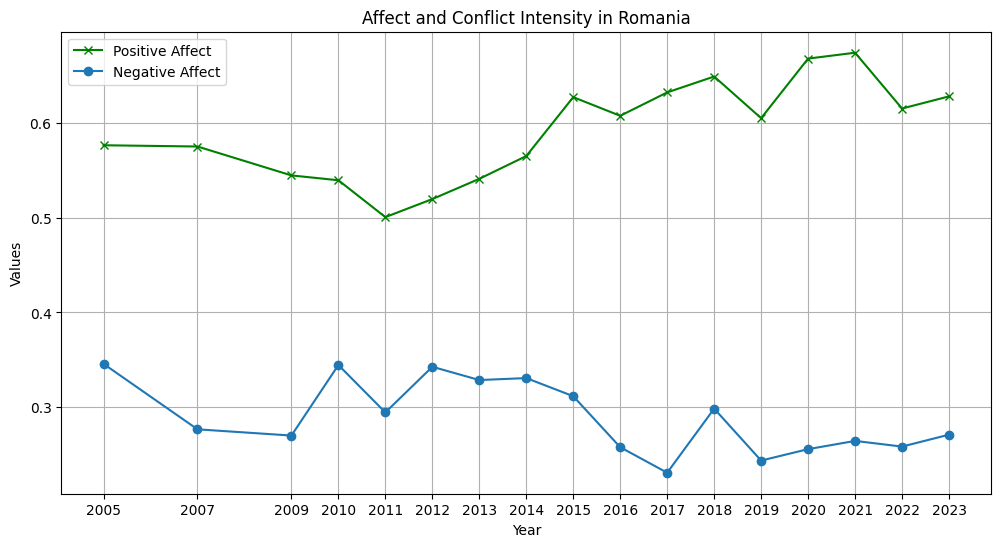

In [24]:
country = 'Romania'

after_2005 = conflictdataframe

conflicts = after_2005[after_2005['location'] == country]
happiness = happinessdataframe[happinessdataframe['Country name'] == country]
    
merged_df = pd.merge(conflicts, happiness, on='year', how='outer')
merged_df.fillna(0, inplace=True)
merged_df = merged_df.sort_values(by='year', ascending=True)
merged_df = merged_df.groupby('year', group_keys=False).apply(select_row)
merged_df = merged_df.loc[(merged_df['Positive affect'] != 0.000) & (merged_df['Negative affect'] != 0.000)]

plt.figure(figsize=(12, 6))
plt.plot(merged_df['year'], merged_df['Positive affect'], label='Positive Affect', color='green', marker='x')
plt.plot(merged_df['year'], merged_df['Negative affect'], label='Negative Affect', marker='o')

for i in range(len(merged_df)):
    intensity_level = merged_df['intensity_level'].iloc[i]
    year = merged_df['year'].iloc[i]
    
    if intensity_level == 1:
        plt.axvspan(year - 0.5, year + 0.5, color='yellow', alpha=0.3, label='Conflict')

for i in range(len(merged_df)):
    intensity_level = merged_df['intensity_level'].iloc[i]
    year = merged_df['year'].iloc[i]
    
    if intensity_level == 2:
        plt.axvspan(year - 0.5, year + 0.5, color='red', alpha=0.3, label='War')

plt.xlabel('Year')
plt.ylabel('Values')
plt.title(f'Affect and Conflict Intensity in {country}')
plt.xticks(merged_df['year'].astype(int))
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))  # Removes duplicates by using dictionary
plt.legend(by_label.values(), by_label.keys())
plt.grid(True)

plt.show()

<h2>Bayesian classifier</h2>

In [ ]:
df = pd.read_excel('final_dataset_processed.xlsx')

X_train, X_test, y_train, y_test = train_test_split(df['Speech'], df['neighbor_in_conflict'], test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer(stop_words='english')
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

model = MultinomialNB()
model.fit(X_train_tfidf, y_train)

y_pred = model.predict(X_test_tfidf)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')
print('Classification Report:')
print(classification_report(y_test, y_pred))